In [3]:
import os

NUM_THREADS = "1"
os.environ["OMP_NUM_THREADS"] = NUM_THREADS
os.environ["OPENBLAS_NUM_THREADS"] = NUM_THREADS
os.environ["MKL_NUM_THREADS"] = NUM_THREADS
os.environ["VECLIB_MAXIMUM_THREADS"] = NUM_THREADS
os.environ["NUMEXPR_NUM_THREADS"] = NUM_THREADS


import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import cluster
import numpy as np

from kneed import KneeLocator

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances_argmin
from yellowbrick.cluster import KElbowVisualizer
scaler = StandardScaler()
min_max_scaler= MinMaxScaler()

sns.set(style="whitegrid")

In [4]:
def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)]) 
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    return centers, labels

In [5]:
def find_optimal_number_of_cluster(group, k_max):
    if type(group) == pd.core.frame.DataFrame:
        group = np.array(group.values.tolist())
    if type(group) == []:
         group = np.array(group)
    scaled_features = scaler.fit_transform(group)
    kmeans_kwargs = {
        "init": "random",
        "n_init": 10,
        "max_iter": 150,
        "random_state": 42,
    }
    # A list holds the SSE values for each k
    sse = []
    for k in range(1,k_max):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(scaled_features)
        sse.append(kmeans.inertia_)
    kl = KneeLocator(range(1, k_max), sse, curve="convex", direction="decreasing")
    return kl.elbow, sse

In [6]:
def clustering(df, df_result, x, y):
    df_result = pd.DataFrame()
    df_normalized = normalize(df)
    if x != y and df[y].dtypes != object:
        group = df_normalized[[x, y]]
        X = np.array(group.values.tolist())
        NUM_CLUSTER, sse = find_optimal_number_of_cluster(X, 11)

        centers, labels = find_clusters(X, NUM_CLUSTER, rseed=0)
        key = x + "_" + y
        df_result[key] = labels
        df[key] = labels
        sns.scatterplot(data=df, x=x, y=y, alpha=0.8, c=labels, s=50, hue=labels) #выводим точечки
        sns.scatterplot(x=centers[:, 0], y=centers[:, 1],  s=250, zorder=2, marker="x", legend=None); #выводим центры
    return df_result

In [7]:
def normalize(df):
    normalize = min_max_scaler.fit_transform(df)
    df_normalized = pd.DataFrame(normalize, columns=df.columns)
    return df_normalized

In [27]:

Y_label = "child_mort"
X_label = "health"
k_max = 11

raw_data = pd.read_csv('dateset/Country-data.csv')
df = raw_data.copy()
df.drop(columns=['country'],inplace=True)

In [11]:
df_normalized_example = normalize(df.copy())
group = df_normalized_example[[X_label,Y_label]]
X = np.array(group.values.tolist())
NUMBER_CLUSTER, sse = find_optimal_number_of_cluster(df_normalized_example[[X_label,Y_label]], k_max)

In [28]:
KMeans_method = cluster.KMeans(init="k-means++", n_clusters=NUMBER_CLUSTER, n_init=10, random_state=24, max_iter=300) #K-Mean
labels_k_mean  = KMeans_method.fit(X).labels_
centers_k_mean = KMeans_method.fit(group).cluster_centers_


centers, labels = find_clusters(X, NUMBER_CLUSTER, rseed=0)


SpectralClustering_method = cluster.SpectralClustering(n_clusters=NUMBER_CLUSTER, affinity='nearest_neighbors', assign_labels='kmeans') #Spectral
labels_spectral = SpectralClustering_method.fit_predict(X)


dbscan = cluster.DBSCAN(eps=0.25) #DBscan
scaled_features = scaler.fit_transform(group)
dbscan.fit(scaled_features)
labels_dbscan = dbscan.labels_


df_normalized_example['algo_max'] = labels
df_normalized_example['k-mean'] = labels_k_mean
df_normalized_example['spectral'] = labels_spectral
df_normalized_example['dbscan'] = labels_dbscan

Text(0.5, 0.98, 'Сomparison of different clasification methods X: health Y: child_mort')

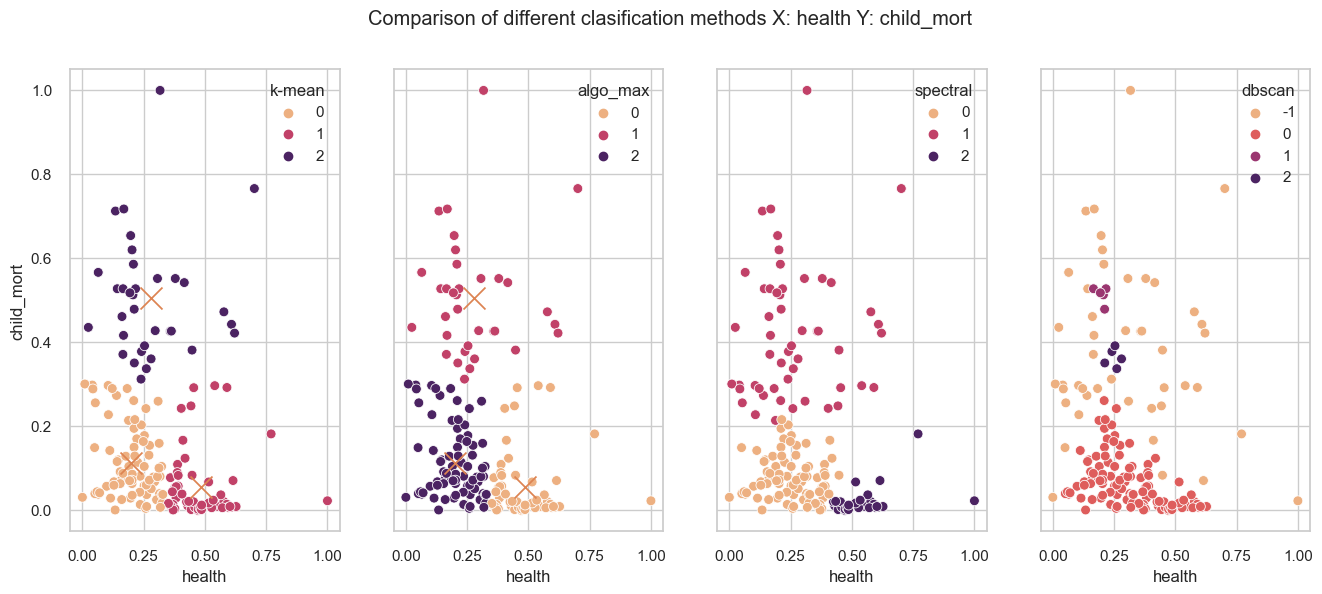

In [13]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 6), sharex=True, sharey=True)


sns.scatterplot(data=df_normalized_example, x=X_label, y=Y_label, hue="k-mean", s=50,alpha=1, palette="flare", ax=ax1)
sns.scatterplot(x=centers_k_mean[:, 0], y=centers_k_mean[:, 1], s=250, zorder=2, marker="x", ax=ax1, legend=None)


sns.scatterplot(data=df_normalized_example, x=X_label, y=Y_label, hue="algo_max", s=50,alpha=1, palette="flare", ax=ax2)
sns.scatterplot(x=centers[:, 0], y=centers[:, 1], s=250, zorder=2, marker="x", ax=ax2, legend=None)


sns.scatterplot(data=df_normalized_example, x=X_label, y=Y_label, hue="spectral", s=50,alpha=1, palette="flare", ax=ax3)

sns.scatterplot(data=df_normalized_example, x=X_label, y=Y_label, hue="dbscan", s=50,alpha=1, palette="flare", ax=ax4)

fig.suptitle("Сomparison of different clasification methods X: {} Y: {}".format(X_label, Y_label))

In [31]:
NUMBER_CLUSTER, sse = find_optimal_number_of_cluster(group, k_max)

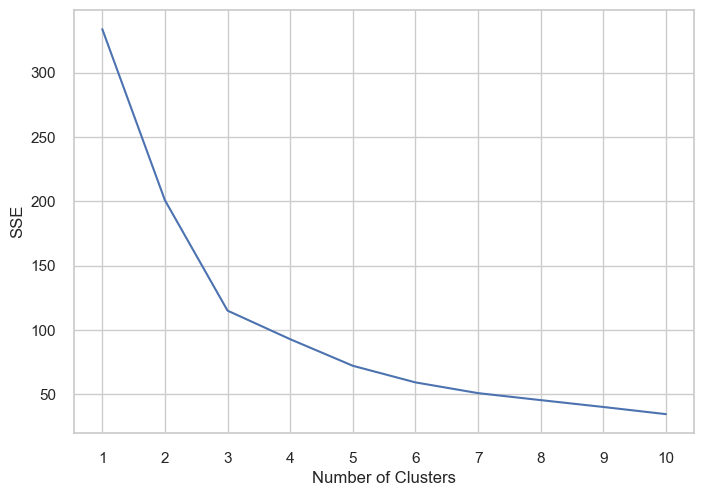

In [32]:
plt.plot(range(1, k_max), sse)
plt.xticks(range(1, k_max))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

Text(0.5, 1.0, 'Feature correlations')

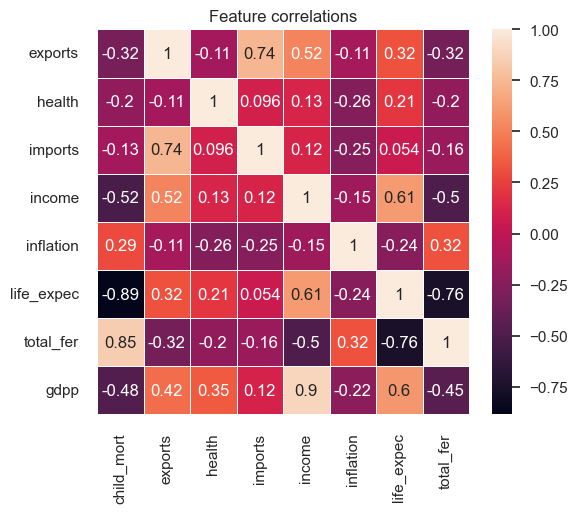

In [29]:
raw_data = pd.read_csv('dateset/Country-data.csv')
df = raw_data.copy()

cors = df.corr()

plt.figure(figsize=(6,5))

df_corr = df.corr().iloc[1:,:-1]
sns.heatmap(df_corr, annot=True, linewidth=0.4)
plt.title("Feature correlations")

In [16]:
#We can see the following from the correlation heatmap:

# -As expected GDPP and income are highly correlated.
# -Number of children born per woman is highly correlated with child mortality, which makes sense.
# -Imports and exports are highly correlated as expected.
# -Life expectancy is highly negatively correlated with child mortality.
# -Life expectancy is correlated with income
# -Life expectancy is correlated with GDPP
#We can safely drop life expectancy, total fertility as they are all very highly correlated to other features
df_clear = df.drop(columns = ['country', 'life_expec', 'total_fer']).copy()

In [30]:
df_normalized = normalize(df_clear)

1    103
0     34
2     30
Name: gdpp_child_mort, dtype: int64

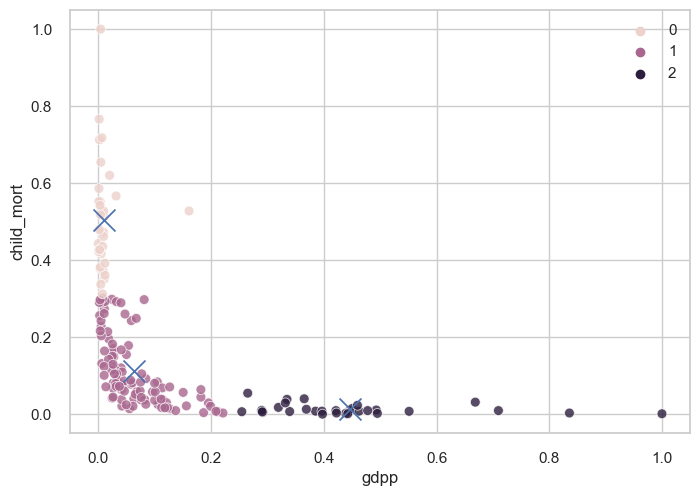

In [33]:
results = pd.DataFrame()
results = clustering(df_normalized, results, 'gdpp', 'child_mort')
results.gdpp_child_mort.value_counts()

1    86
0    51
3    25
2     5
Name: gdpp_imports, dtype: int64

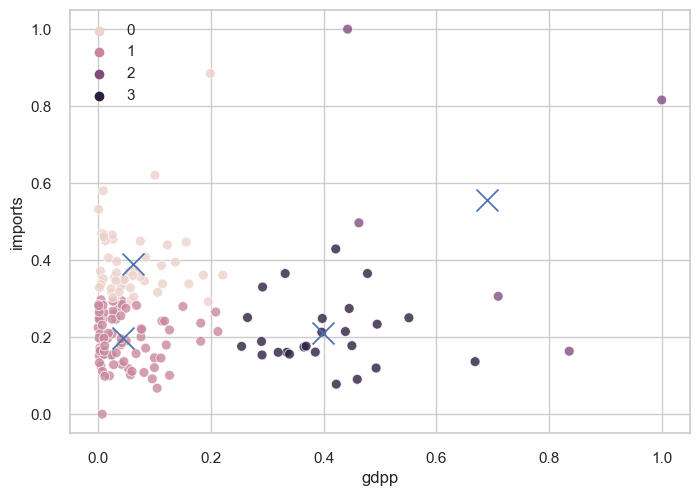

In [34]:
results = clustering(df_normalized, results, 'gdpp', 'imports')
results.gdpp_imports.value_counts()

1    98
0    47
2    22
Name: gdpp_health, dtype: int64

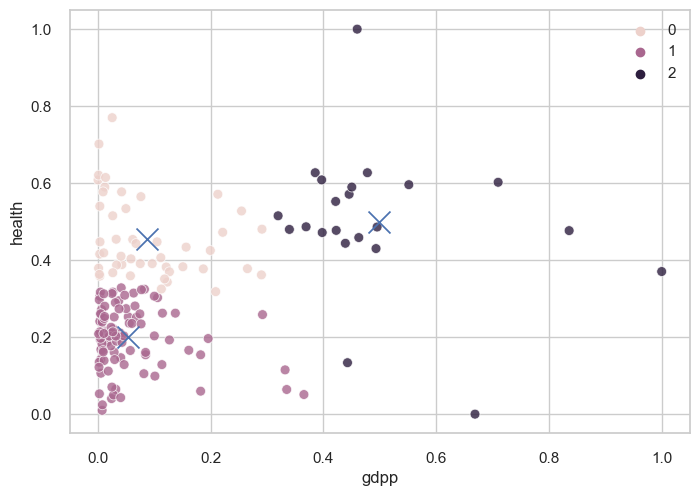

In [35]:
results = clustering(df_normalized, results, 'gdpp', 'health')
results.gdpp_health.value_counts()

In [36]:
model = KMeans(n_clusters=4, random_state=123)
model.fit(df_normalized)

df['cluster'] = model.labels_
df.cluster.value_counts()

2    58
0    45
3    34
1    30
Name: cluster, dtype: int64

In [37]:
clusters = df.groupby(['cluster']).mean()
clusters

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
cluster,,,,,,,,,
0,21.771111,54.295556,6.763778,67.473333,12568.888889,5.209533,71.464444,2.425111,7050.977778
1,5.226667,54.706667,8.911333,46.843333,48596.666667,2.754367,80.323333,1.810333,47053.333333
2,28.222414,31.392741,6.067586,33.085619,12691.724138,9.776224,72.156897,2.568621,6713.844828
3,106.402941,28.232941,6.311471,43.238235,3045.382353,12.220147,58.002941,5.290882,1374.029412


In [39]:
df[df.cluster==3].head(10).sort_values(["gdpp"])

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
26,Burundi,93.6,8.92,11.60,39.2,764,12.300,57.7,6.26,231,3
37,"Congo, Dem. Rep.",116.0,41.10,7.91,49.6,609,20.800,57.5,6.54,334,3
31,Central African Republic,149.0,11.80,3.98,26.5,888,2.010,47.5,5.21,446,3
0,Afghanistan,90.2,10.00,7.58,44.9,1610,9.440,56.2,5.82,553,3
25,Burkina Faso,116.0,19.20,6.74,29.6,1430,6.810,57.9,5.87,575,3
17,Benin,111.0,23.80,4.10,37.2,1820,0.885,61.8,5.36,758,3
36,Comoros,88.2,16.50,4.51,51.7,1410,3.870,65.9,4.75,769,3
32,Chad,150.0,36.80,4.53,43.5,1930,6.390,56.5,6.59,897,3
28,Cameroon,108.0,22.20,5.13,27.0,2660,1.910,57.3,5.11,1310,3
3,Angola,119.0,62.30,2.85,42.9,5900,22.400,60.1,6.16,3530,3
